In the previous router, we invoke the model and, if it chose to call a tool, we returned a ToolMessage to the User.
But, What if we simply pass that ToolMessage back to the model ?
We can lete it either (1) call another tool or (2) respond directly
This is the intuition behind ReAct agent, a general agent architecture

act - let the model call specific tools observe - pass the tool output back to the model reason - let the model reason about the tool output to decide what to do next (e.g (1) call another tool or (2) respond directly)

In [15]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

# llm = ChatGroq(model="qwen-2.5-32b")

In [16]:
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """
    Subtract the second integer from the first integer.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The difference between a and b.
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

def divide(a: int, b: int) -> float:
    """
    Divide the first integer by the second integer.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        float: The quotient of a divided by b.

    Raises:
        ValueError: If b is zero.
    """
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b

In [17]:
tools = [add, subtract, multiply, divide]

In [18]:
llm = ChatOpenAI(model="gpt-4o")

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [19]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

# from langgraph.graph import MessagesState # direct use it

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [20]:
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant task with performing arithematic operations on a set of inputs. "
)

def assistant(state: MessagesState) -> MessagesState:
    return {
        "messages": [
            llm_with_tools.invoke([sys_msg] + state["messages"])
        ]
    }

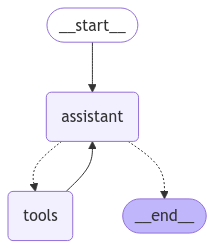

In [23]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)
# Define the node
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

## Define the edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant", 
    # if the latest message (result) from assistant is a tool call -> tools_condition rotes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [24]:
messages = [
    HumanMessage(content="Add 10 and 14. Multiply the output by 2. Divide the output by 5."),
]
messages = react_graph.invoke({"messages": messages})

In [26]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 14. Multiply the output by 2. Divide the output by 5.
================================== Ai Message ==================================
Tool Calls:
  add (call_oQfEEOVrD4FkdpfLeXg7ebpM)
 Call ID: call_oQfEEOVrD4FkdpfLeXg7ebpM
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7nUI73CvjGTAQw231TBSYKfu)
 Call ID: call_7nUI73CvjGTAQw231TBSYKfu
  Args:
    a: 24
    b: 2
================================= Tool Message =================================
Name: multiply

48
================================== Ai Message ==================================
Tool Calls:
  divide (call_2Ad7TiFl6nH8HnkICOLOyXQV)
 Call ID: call_2Ad7TiFl6nH8HnkICOLOyXQV
  Args:
    a: 48
    b: 5
================================= Tool Message ========

In [27]:
messages = [
    HumanMessage(content="10 + (5 X 3 + 2)"),
]
messages = react_graph.invoke({"messages": messages})

In [28]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

10 + (5 X 3 + 2)
================================== Ai Message ==================================
Tool Calls:
  multiply (call_sAyEUb0cEUiFQtpgcptRT66E)
 Call ID: call_sAyEUb0cEUiFQtpgcptRT66E
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================
Tool Calls:
  add (call_d05jCFQs4STrwoiw1U1ZkZu9)
 Call ID: call_d05jCFQs4STrwoiw1U1ZkZu9
  Args:
    a: 15
    b: 2
================================= Tool Message =================================
Name: add

17
================================== Ai Message ==================================
Tool Calls:
  add (call_2joEfBs3jqv972r7qkjLYIls)
 Call ID: call_2joEfBs3jqv972r7qkjLYIls
  Args:
    a: 10
    b: 17
================================= Tool Message =================================
Name: add

27
============

In [31]:
messages = [
    HumanMessage(content="Add 14 and 15"),
]
messages = react_graph.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 14 and 15
================================== Ai Message ==================================
Tool Calls:
  add (call_LK7OU71KkrVK4h03CjvNrkYu)
 Call ID: call_LK7OU71KkrVK4h03CjvNrkYu
  Args:
    a: 14
    b: 15
================================= Tool Message =================================
Name: add

29
================================== Ai Message ==================================

The sum of 14 and 15 is 29.


In [32]:
messages = [
    HumanMessage(content="Multiply that by 3"),
]
messages = react_graph.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 3
================================== Ai Message ==================================

Could you provide the number you would like to multiply by 3?


## Memory in agents using MemorySaver

In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)

In [22]:
config = {"configurable": {"thread_id": "1"}}

# specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph.invoke({"messages": messages}, config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_EKVF9mflAF7uBOeAVjxnkMBi)
 Call ID: call_EKVF9mflAF7uBOeAVjxnkMBi
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [23]:
messages = [
    HumanMessage(content="Multiply that by 3"),
]
messages = react_graph.invoke({"messages": messages}, config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_EKVF9mflAF7uBOeAVjxnkMBi)
 Call ID: call_EKVF9mflAF7uBOeAVjxnkMBi
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_r5Tb8sPwEeqEtggWUJlPJVpD)
 Call ID: call_r5Tb8sPwEeqEtggWUJlPJVpD
  Args:
    a: 7
    b: 3
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message ==================================

The result of multiply

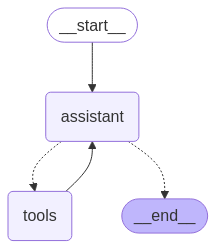

In [12]:
# deepseek with ollama

from langchain_ollama import ChatOllama

llm = ChatOllama(model="MFDoom/deepseek-r1-tool-calling", temperature=0.2)

llm_with_tools = llm.bind_tools(tools)

from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)
# Define the node
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

## Define the edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant", 
    # if the latest message (result) from assistant is a tool call -> tools_condition rotes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()
display(Image(react_graph.get_graph().draw_mermaid_png()))



In [14]:
messages = [
    HumanMessage(content="Add 10 and 14."),
]
config = {"recursion_limit": 1000}
messages = react_graph.invoke({"messages": messages}, config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (200a68c6-507d-41b8-bf80-4f3668ad36aa)
 Call ID: 200a68c6-507d-41b8-bf80-4f3668ad36aa
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================
Tool Calls:
  add (acbc278f-2310-4af4-8073-58c3e12d1952)
 Call ID: acbc278f-2310-4af4-8073-58c3e12d1952
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================

<think>
Okay, so I need to add 10 and 14. Hmm, let me think about how addition works. Addition is basically combining two numbers together to get a total sum. So in this case, I have the number 10 and I'm 